<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img>
<img src="https://github.com/LinkedEarth/Logos/blob/master/LinkedEarth/LinkedEarth_medium.png?raw=true" width=400 alt="LinkedEarth Logo"></img>

# Investigating interhemispheric precipitation changes over the past millennium

---

## Overview

This CookBook demonstrates how to compare paleoclimate model output and proxy observations using EOF to identify large-scale spatio-temporal patterns in the data. It is inspired from a study by [Steinman et al. (2022)](https://doi.org/10.1073/pnas.2120015119) although it reuses different datasets.  

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |
| [Intro to Pandas](https://foundations.projectpythia.org/core/pandas.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Necessary | |
| [Using xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary | Familiarity with understanding opening multiple files and merging |
|EOF (PCA) Analysis - See Chapter 12 of [this book](https://figshare.com/articles/book/Data_Analysis_in_the_Earth_Environmental_Sciences/1014336)|Helpful|Familiarity with the concepts is helpful for interpretation of the results|
|[eofs package](https://ajdawson.github.io/eofs/)|Helpful|A good introduction on the package can be found in [this notebook](https://projectpythia.org/eofs-cookbook/README.html)|
|[Using Pyleoclim for Paleoclimate Data](http://linked.earth/PyleoTutorials/intro.html)|Helpful||
|[SPARQL](https://www.w3.org/TR/sparql11-query/)|Familiarity|Query language for graph database|

- **Time to learn**: 40 min.

---

## Imports

In [1]:
#To deal with model data
import s3fs
import fsspec
import xarray as xr
import glob

#To deal with proxy data
import pandas as pd
import numpy as np
import json
import requests
import pandas as pd
import io
import ast

#To deal with analysis
import pyleoclim as pyleo
from eofs.xarray import Eof

#Plotting and mapping
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import nc_time_axis
from matplotlib import gridspec
from matplotlib.colors import Normalize

## PCA analysis on proxy observations

After looking at the model data, let's have a look at the proxy datasets.

### Query to remote database

The first step is the query the [LinkedEarth](https://linkedearth.graphdb.mint.isi.edu/) Graph Database for relevant datasets for comparison with the model. 

The database uses the SPARQL language for queries. We are filtering the database for the following criteria:
* Datasets bounded by 27°S-27°N and 70°W-150°W
* Datasets from the [Pages2k](https://lipdverse.org/project/pages2k/), [Iso2k](https://lipdverse.org/project/iso2k/), [CoralHydro2k](https://essd.copernicus.org/articles/15/2081/2023/essd-15-2081-2023-discussion.html) and [SISAL](https://essd.copernicus.org/articles/12/2579/2020/) working groups. These working groups identified archived datasets that were sensitive to temperature and the isotopic composition of precipication (precipitation $\delta{18}$O) and curated them for use in a standardized database.
* Timeseries within these datasets representing precipitation.

We asked for the following information back:
* The name of the dataset
* Geographical Location of the record expressed in latitude and longitude
* The type of archive (e.g., speleothem, Lake sediment) the measurements were made on
* The name of the variable
* The values and units of the measurements
* The time information (values and units) associated with the variable of interest.

The following cell points to the query API and creates the query itself.

In [2]:
url = 'https://linkedearth.graphdb.mint.isi.edu/repositories/LiPDVerse-dynamic'

query = """PREFIX le: <http://linked.earth/ontology#>
PREFIX wgs84: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT distinct?varID ?dataSetName ?lat ?lon ?varname ?interpLabel ?val ?varunits ?timevarname ?timeval ?timeunits ?archiveType where{

    ?ds a le:Dataset .
    ?ds le:hasName ?dataSetName .
    OPTIONAL{?ds le:hasArchiveType ?archiveTypeObj .
             ?archiveTypeObj rdfs:label ?archiveType .}
    
    
    ?ds le:hasLocation ?loc .
    ?loc wgs84:lat ?lat .
    FILTER(?lat<26 && ?lat>-26) 
    ?loc wgs84:long ?lon .
    FILTER(?lon<-70 && ?lon>-150) 
    
    ?ds le:hasPaleoData ?data .
    ?data le:hasMeasurementTable ?table .
    ?table le:hasVariable ?var .
    ?var le:hasName ?varname .
    VALUES ?varname {"d18O"} .
    ?var le:partOfCompilation  ?comp .
    ?comp le:hasName ?compName .
    VALUES ?compName {"iso2k" "Pages2kTemperature" "CoralHydro2k" "SISAL-LiPD"} .
    ?var le:hasInterpretation ?interp .
    ?interp le:hasVariable ?interpVar .
    ?interpVar rdfs:label ?interpLabel .
    FILTER (REGEX(?interpLabel, "precipitation.*", "i"))
    ?var le:hasVariableId ?varID .
    ?var le:hasValues ?val .
    OPTIONAL{?var le:hasUnits ?varunitsObj .
    		?varunitsObj rdfs:label ?varunits .}
    
    ?table le:hasVariable ?timevar .
    ?timevar le:hasName ?timevarname .
    VALUES ?timevarname {"year" "age"} .
    ?timevar le:hasValues ?timeval .
    OPTIONAL{?timevar le:hasUnits ?timeunitsObj .
    		 ?timeunitsObj rdfs:label ?timeunits .}  
}"""

The following cell sends the query to the database and returns the results in a Pandas Dataframe.

In [3]:
response = requests.post(url, data = {'query': query})

data = io.StringIO(response.text)
df_res = pd.read_csv(data, sep=",")

df_res['val']=df_res['val'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)
df_res['timeval']=df_res['timeval'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)

df_res.head()

,varID,dataSetName,lat,lon,varname,interpLabel,val,varunits,timevarname,timeval,timeunits,archiveType
0,TR04EVLI01,TR04EVLI,10.000,-85.000,d18O,precipitationIsotope,"[23.69, 24.29, 24.25, 24.74, 25.7, 26.33, 26.0...",permil,year,"[2000.75, 2000.73, 2000.72, 2000.71, 2000.7, 2...",yr AD,Wood
1,TR04EVLI01,TR04EVLI,10.000,-85.000,d18O,precipitation,"[23.69, 24.29, 24.25, 24.74, 25.7, 26.33, 26.0...",permil,year,"[2000.75, 2000.73, 2000.72, 2000.71, 2000.7, 2...",yr AD,Wood
2,SP09REPE01A,SP09REPE,-6.067,-77.183,d18O,precipitationIsotope,"[-6102.0, -6987.0, -6841.0, -7136.0, -6968.0, ...",permil,year,"[-198618, -2002417, -2001113, -1999809, -19985...",yr AD,Speleothem
3,SP09REPE01A,SP09REPE,-6.067,-77.183,d18O,precipitation,"[-6102.0, -6987.0, -6841.0, -7136.0, -6968.0, ...",permil,year,"[-198618, -2002417, -2001113, -1999809, -19985...",yr AD,Speleothem
4,SP09REPE02A,SP09REPE,-6.067,-77.183,d18O,precipitationIsotope,"[-6751.0, -6971.0, -6876.0, -6824.0, -6771.0, ...",permil,year,"[-1905513, -1903265, -1900455, -1897645, -1894...",yr AD,Speleothem


We have retrieved the following number of proxy records: 

In [4]:
len(df_res)

106

Make sure we have unique timeseries (some may be found across compilations): 

In [5]:
df = df_res[~df_res['varID'].duplicated()]

In [6]:
len(df)

44

The first step is to make sure that everything is on the same representation of the time axis. Year is considered prograde while age is considered retrograde:

In [7]:
df['timevarname'].unique()

array(['year', 'age'], dtype=object)

Since we have records expressed in both year and age, let's convert everything to year. First let's have a look at the units:

In [8]:
df['timeunits'].unique()

array(['yr AD', 'yr BP'], dtype=object)

The units for age are expressed in BP (before present), if we assume the present to be 1950 by convention, then we can transform:

In [9]:
df['timeval'] = df['timeval'].apply(np.array)

def adjust_timeval(row):
    if row['timevarname'] == 'age':
        return 1950 - row['timeval']
    else:
        return row['timeval']

# Apply the function across the DataFrame rows
df['timeval'] = df.apply(adjust_timeval, axis=1)

It is obvious that some of the timeseries do not have correct time information (e.g., row 2). Let's filter the dataframe to make sure that the time values are within 0-2000 and that there is at least 1500 years of record:

In [10]:
def range_within_limits(array, lower = 0, upper = 2000, threshold = 1500):
    filtered_values = array[(array >= lower) & (array <= upper)]
    if filtered_values.size > 0:  # Check if there are any values within the range
        return np.ptp(filtered_values) >= threshold  # np.ptp() returns the range of values
    return False  # If no values within the range, filter out the row


# Apply the function to filter the DataFrame
filtered_df = df[df['timeval'].apply(range_within_limits)]

We are now left with:

In [11]:
len(filtered_df)

17

Let's also make sure that the records are long enough (i.e., more than 1500 years long):

In [12]:
def array_range_exceeds(array, threshold=1500):
    return np.max(array) - np.min(array) > threshold

filt_df = filtered_df[filtered_df['timeval'].apply(array_range_exceeds)]

This leaves us with the following number of datasets:

In [13]:
len(filt_df)

16

Let's filter for records with a resolution finer or equal to 60 years:

In [14]:
def min_resolution(array, min_res=60):
    if len(array) > 1:  # Ensure there are at least two points to calculate a difference
        # Calculate differences between consecutive elements
        differences = np.mean(np.diff(array))
        # Check if the minimum difference is at least 50
        return abs(differences) <= min_res
    return False  # If less than two elements, can't compute difference

# Apply the function and filter the DataFrame
filtered_df2 = filt_df[filt_df['timeval'].apply(min_resolution)]

This leaves us with the following number of datasets:

In [15]:
len(filtered_df2)

13

Next, let's use the [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) software package and create individual [GeoSeries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#geoseries-pyleoclim-geoseries) objects:

In [16]:
ts_list = []
for _, row in filtered_df2.iterrows():
        ts_list.append(pyleo.GeoSeries(time=row['timeval'],value=row['val'],
                                   time_name='year',value_name=row['varname'],
                                   time_unit='CE', value_unit=row['varunits'],
                                   lat = row['lat'], lon = row['lon'],
                                   archiveType = row['archiveType'], verbose = False, 
                                   label=row['dataSetName']+'_'+row['varname']))

        #print(row['timeval'])

Now let's use a [MultipleGeoSeries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#multiplegeoseries-pyleoclim-multiplegeoseries) object for visualization and analysis: 

In [17]:
mgs = pyleo.MultipleGeoSeries(ts_list, label='HydroAm2k', time_unit='year CE') 

Let's first map the location of the records by the type of archive:

(<Figure size 1600x600 with 2 Axes>,
 {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >})

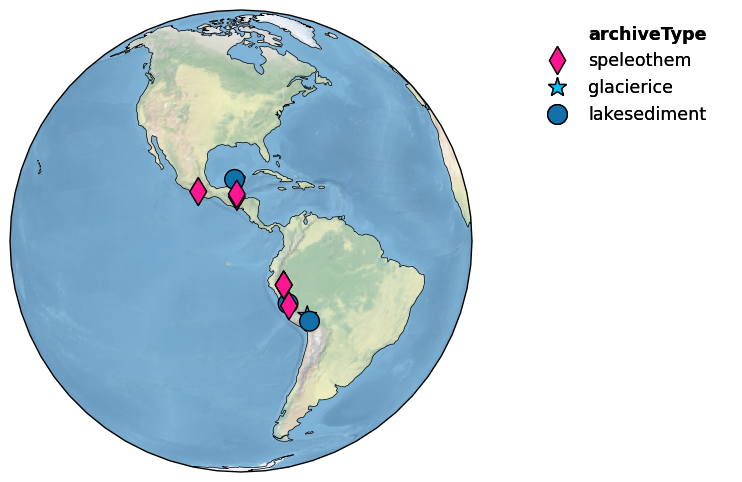

In [18]:
mgs.map()

Let's have a look at the records, sliced for the 0-2000 period

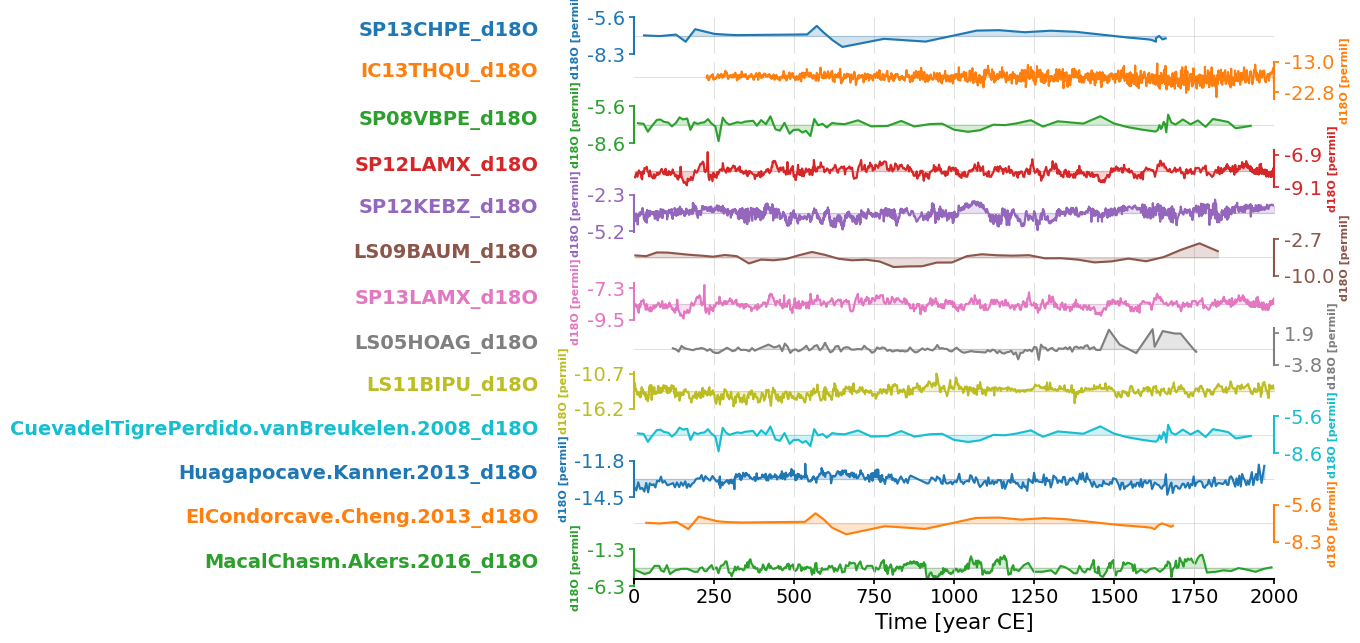

In [19]:
fig, ax = mgs.sel(time=slice(0,2000)).stackplot(v_shift_factor=1.2)
plt.show(fig)

### Run PCA Analysis

Let's place them on a common time axis for analysis and standardize:

In [20]:
mgs_common = mgs.sel(time=slice(850,2000)).common_time().standardize()

In [21]:
pca = mgs_common.pca()

Let's have a look at the screeplot:

The provided eigenvalue array has only one dimension. UQ defaults to NB82


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'HydroAm2k PCA eigenvalues'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

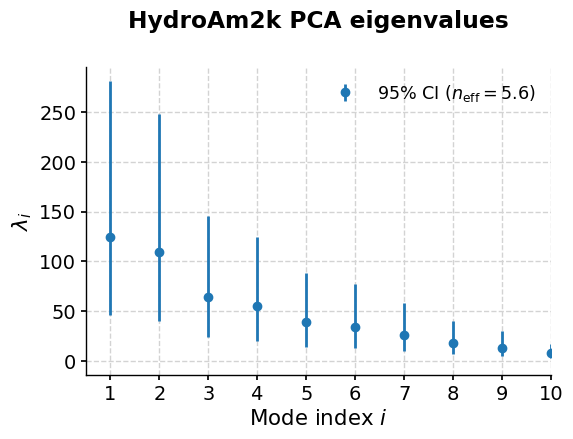

In [22]:
pca.screeplot()

As is nearly always the case with geophysical timeseries, the first few of eigenvalues trully overwhelm the rest. In this case, let's have a look at the first three.  

(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year CE]', ylabel='$PC_1$'>,
  'psd': <Axes: xlabel='Period [year]', ylabel='PSD'>,
  'map': {'cb': <Axes: ylabel='EOF'>,
   'map': <GeoAxes: xlabel='lon', ylabel='lat'>}})

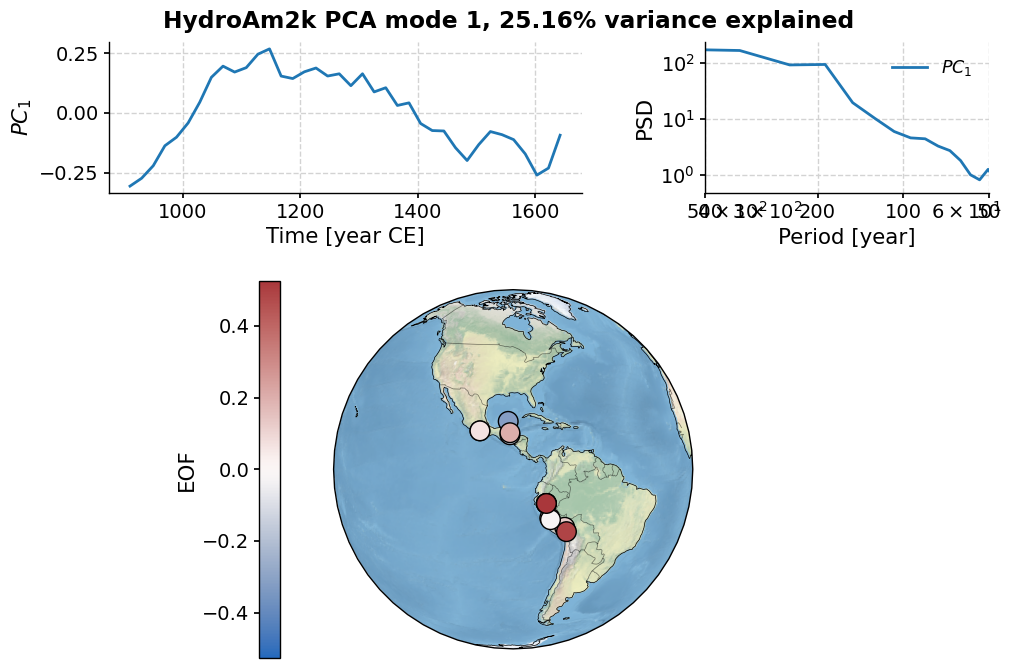

In [23]:
pca.modeplot()

Let's have a look at the second mode: 

(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year CE]', ylabel='$PC_2$'>,
  'psd': <Axes: xlabel='Period [year]', ylabel='PSD'>,
  'map': {'cb': <Axes: ylabel='EOF'>,
   'map': <GeoAxes: xlabel='lon', ylabel='lat'>}})

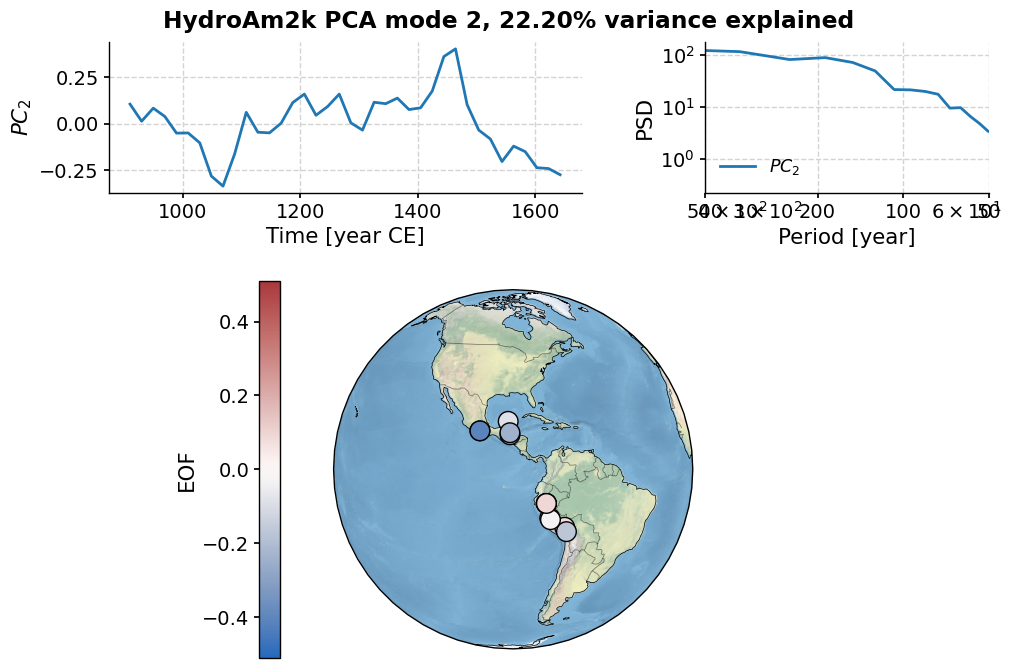

In [24]:
pca.modeplot(index=1)

Finally, let's have a look at the third mode:

(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year CE]', ylabel='$PC_3$'>,
  'psd': <Axes: xlabel='Period [year]', ylabel='PSD'>,
  'map': {'cb': <Axes: ylabel='EOF'>,
   'map': <GeoAxes: xlabel='lon', ylabel='lat'>}})

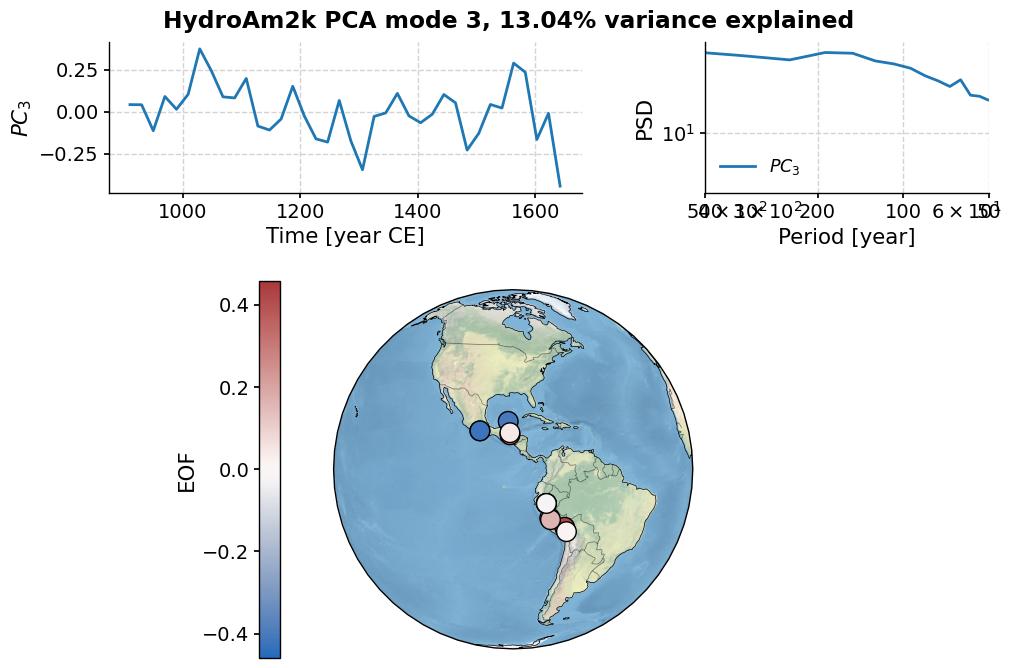

In [25]:
pca.modeplot(index=2)

As you can see, the first three modes explain 60% of the variance.

## PCA analysis on the CESM Last Millennium Ensemble

The first step is the calculate precipitation $\delta^{18}O$ for the all forcings simulation. The following section demonstrates how to get the data from JetStream2 and pre-process each file to save the needed variable and place them into a new `xarray.Dataset`. This process can be time-consuming. 

### Get the CESM Last Millennium Ensemble data from JetStream2

Let's open the needed files for this analysis, which consists of various precipitation isotopes. All data have been made available on NSF JetStream2.

In [26]:
URL = 'https://js2.jetstream-cloud.org:8001/' #Locate and read a file

In [27]:
path = f'pythia/cesmLME' # specify data location

In [28]:
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL)) 
pattern = f's3://{path}/*.nc'
files = sorted(fs.glob(pattern))

Let's open relevant files for the all forcing simulations ('LME.002') for the 850-1850 period:

In [29]:
base_name = 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.'
time_period =  '085001-184912'

names = [name for name in files if base_name in name and time_period in name]

names

['pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRC_H216Or.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRC_H218Or.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRL_H216OR.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRL_H218OR.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSC_H216Os.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSC_H218Os.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSL_H216OS.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSL_H218OS.085001-184912.nc']

In [30]:
fileset = [fs.open(file) for file in names]

Next, let's open these datasets and extract the needed variables into another `xarray.Dataset`. 

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Note that this cell may take some time to run! On a 2024 MacBook pro with an M3 chip, it took about 7minutes.
</div>

In [31]:
%%time
for idx,item in enumerate(fileset):
    ds_u = xr.open_dataset(item)
    var_name = names[idx].split('.')[-3] #This uses the file name to obtain the variable name. 
    da = ds_u[var_name]
    try:
        ds[var_name]= da
    except:
        ds = da.to_dataset()
        ds.attrs = ds_u.attrs 
    ds_u.close()
    da.close()

CPU times: user 11.9 s, sys: 11.9 s, total: 23.8 s
Wall time: 32.7 s


And we're done! Let's have a look at the data we will be working with:

In [32]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:        (lat: 96, lon: 144, time: 12000)
Coordinates:
  * lat            (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon            (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time           (time) object 96kB 0850-02-01 00:00:00 ... 1850-01-01 00:0...
Data variables:
    PRECRC_H216Or  (time, lat, lon) float32 664MB ...
    PRECRC_H218Or  (time, lat, lon) float32 664MB ...
    PRECRL_H216OR  (time, lat, lon) float32 664MB ...
    PRECRL_H218OR  (time, lat, lon) float32 664MB ...
    PRECSC_H216Os  (time, lat, lon) float32 664MB ...
    PRECSC_H218Os  (time, lat, lon) float32 664MB ...
    PRECSL_H216OS  (time, lat, lon) float32 664MB ...
    PRECSL_H218OS  (time, lat, lon) float32 664MB ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.ie12.B1850C5CN.f19_g16.LME.002
    title:            UNSET
    logname:          tomas
    host:             r1i0n5
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.ie12.B1850CN.f19_g16.850cntl.001.cam.i.0850-01-01-000...
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/consisten...

### Select the tropical Central and South America region

Let's look at the region bounded by 27°S-27°N and 70°W-150°W:

In [33]:
ds_geo_all = ds.sel(lat=slice(-27,27), lon=slice(250,330))

Since the loading and pre-processing of the files take a long time, let's save a version of this dataset in netCDF for further use:

In [34]:
#ds_geo.to_netcdf(path='../data/LME.002.cam.h0.precip_iso.085001-184912.nc')

For model-data comparison, it might be useful to resample the model data on the proxy scales:

In [35]:
print("The minimum time is: "+str(np.min(mgs_common.series_list[0].time)))
print("The maximum time is: "+str(np.max(mgs_common.series_list[0].time)))
print("The resolution is: "+str(np.mean(np.diff(mgs_common.series_list[0].time))))

The minimum time is: 909.9999999721545
The maximum time is: 1642.5572719757952
The resolution is: 19.798845189287587


In [36]:
ds_geo_time = ds_geo_all.sel(time=slice("0910-01-01 00:00:00" ,"1642-12-01 00:00:00"))

And resample to the proxy resolution (~20yr as calculated above):

In [37]:
ds_geo = ds_geo_time.resample(time='20A').mean()

ds_geo

<xarray.Dataset> Size: 1MB
Dimensions:        (time: 38, lat: 28, lon: 33)
Coordinates:
  * lat            (lat) float64 224B -25.58 -23.68 -21.79 ... 21.79 23.68 25.58
  * lon            (lon) float64 264B 250.0 252.5 255.0 ... 325.0 327.5 330.0
  * time           (time) object 304B 0910-12-31 00:00:00 ... 1650-12-31 00:0...
Data variables:
    PRECRC_H216Or  (time, lat, lon) float32 140kB 2.702e-08 ... 6.263e-09
    PRECRC_H218Or  (time, lat, lon) float32 140kB 2.691e-08 ... 6.246e-09
    PRECRL_H216OR  (time, lat, lon) float32 140kB 3.247e-09 ... 4.477e-10
    PRECRL_H218OR  (time, lat, lon) float32 140kB 3.215e-09 ... 4.467e-10
    PRECSC_H216Os  (time, lat, lon) float32 140kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PRECSC_H218Os  (time, lat, lon) float32 140kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PRECSL_H216OS  (time, lat, lon) float32 140kB 1.908e-16 ... 2.612e-17
    PRECSL_H218OS  (time, lat, lon) float32 140kB 1.823e-16 ... 2.499e-17
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.ie12.B1850C5CN.f19_g16.LME.002
    title:            UNSET
    logname:          tomas
    host:             r1i0n5
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.ie12.B1850CN.f19_g16.850cntl.001.cam.i.0850-01-01-000...
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/consisten...

### Calculate Precipitation $\delta^{18}$O

In [38]:
%%time
p16O = ds_geo['PRECRC_H216Or'] + ds_geo['PRECSC_H216Os'] + ds_geo['PRECRL_H216OR'] + ds_geo['PRECSL_H216OS']
p18O = ds_geo['PRECRC_H218Or'] + ds_geo['PRECSC_H218Os'] + ds_geo['PRECRL_H218OR'] + ds_geo['PRECSL_H218OS']

p16O = p16O.where(p16O > 1e-18, 1e-18)
p18O = p18O.where(p18O > 1e-18, 1e-18)

d18Op = (p18O / p16O - 1)*1000

CPU times: user 2.44 ms, sys: 3.26 ms, total: 5.7 ms
Wall time: 5.5 ms


### Run PCA analysis

Let's first standardize the data: 

In [39]:
d18Oa = (d18Op - d18Op.mean(dim='time'))/d18Op.std(dim='time')

Create an EOF solver to do the EOF analysis.

In [40]:
solver = Eof(d18Oa, weights=None)

Retrieve the leading EOF, expressed as the covariance between the leading PC time series and the input d18O anomalies at each grid point.

In [41]:
eof1 = solver.eofsAsCovariance(neofs=3)

Plot the leading EOF expressed covariance

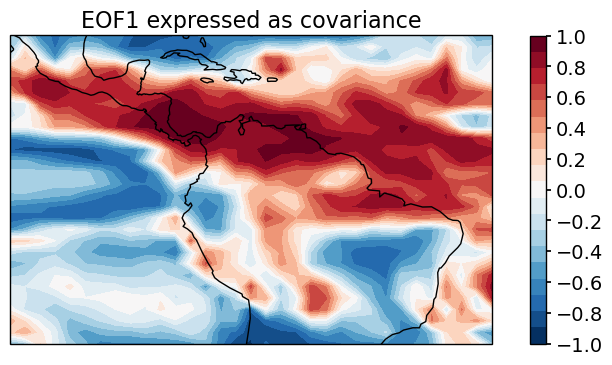

In [42]:
clevs = np.linspace(-1, 1, 20)
proj = ccrs.PlateCarree(central_longitude=290)
fig, ax = plt.subplots(figsize=[10,4], subplot_kw=dict(projection=proj))
ax.coastlines()
eof1[0].plot.contourf(ax=ax, levels = clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
fig.axes[1].set_ylabel('')
fig.axes[1].set_yticks(np.arange(-1,1.2,0.2))
ax.set_title('EOF1 expressed as covariance', fontsize=16)
plt.show()

Let's have a look at the first three PCs:

In [43]:
pcs = solver.pcs(npcs=3, pcscaling=1)

Text(0.5, 1.0, 'PC1 Time Series')

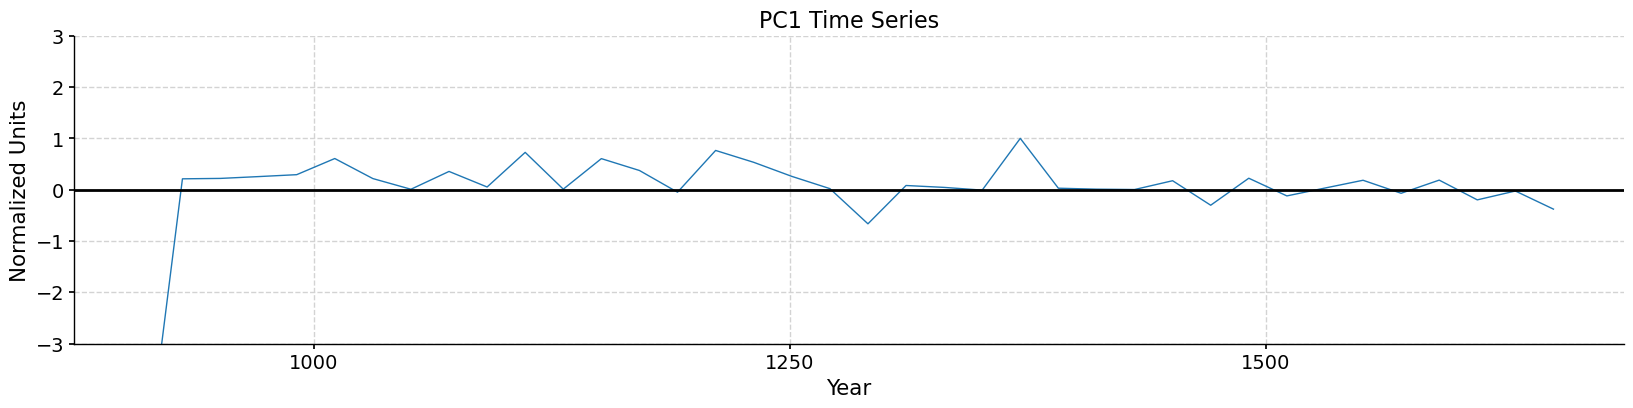

In [44]:
fig, ax = plt.subplots(figsize=[20,4])
pcs[:, 0].plot(ax=ax, linewidth=1)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

## Model-Data Comparison

Let's map the first EOF for the model and data and the first PC.

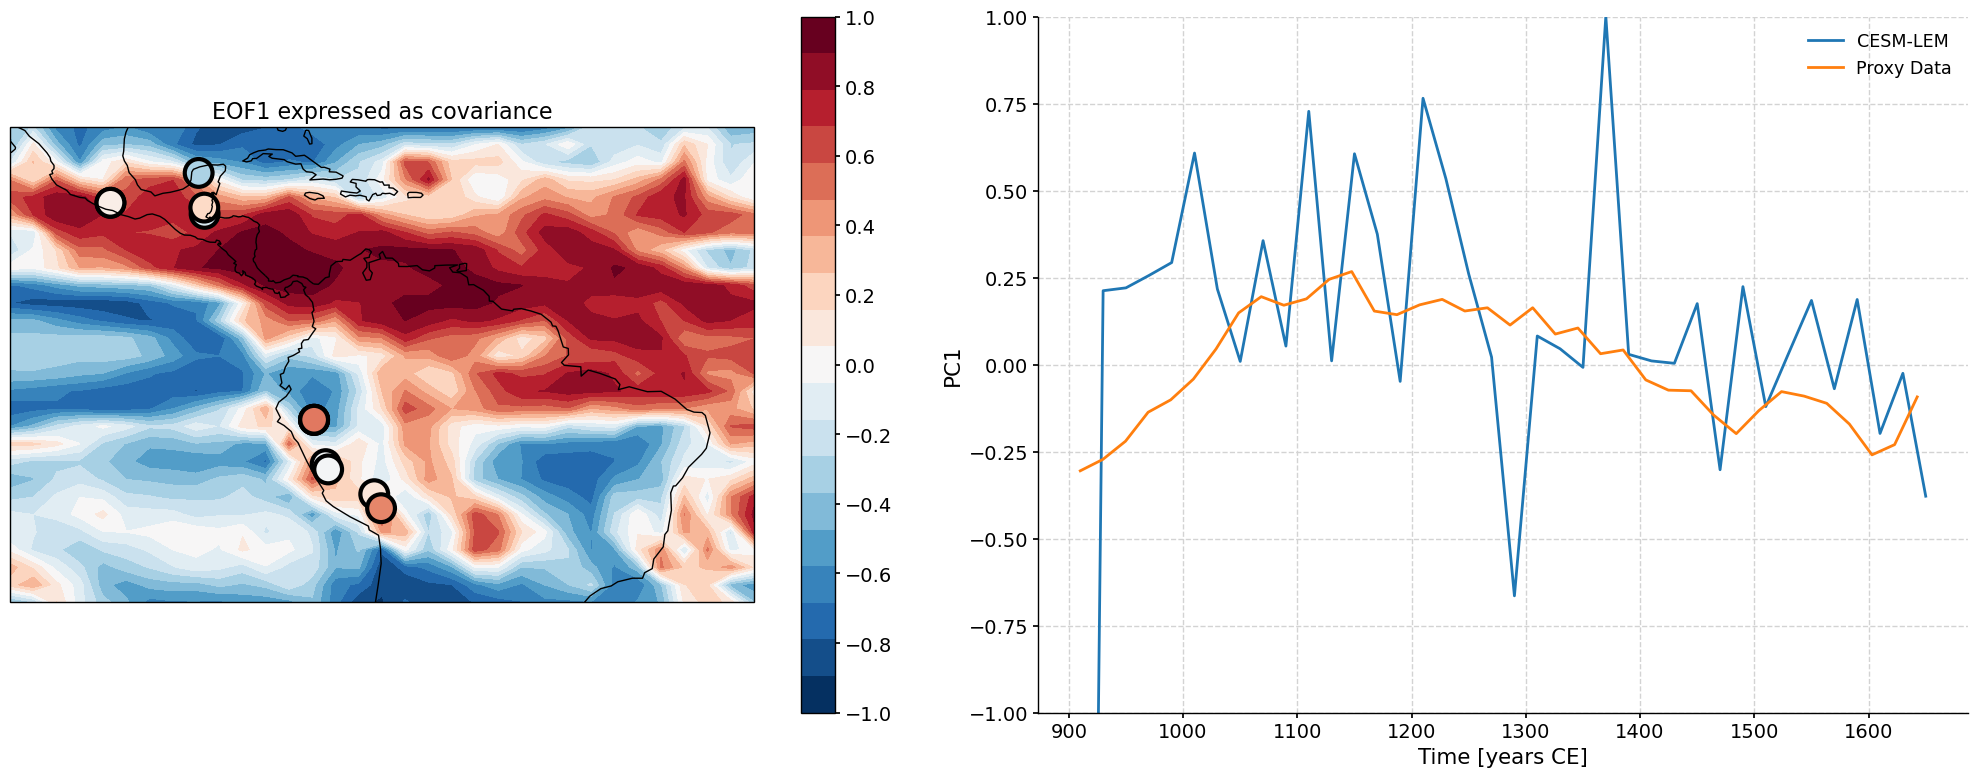

In [45]:
# Create a figure

fig = plt.figure(figsize=[20,8])

# Define the GridSpec
gs = gridspec.GridSpec(1, 2, figure=fig)

# Add a geographic map in the first subplot using Cartopy

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=290))
ax1.coastlines()  # Add coastlines to the map

# Plot the model results
norm = Normalize(vmin=-1, vmax=1)
eof1[0].plot.contourf(ax=ax1, levels = clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True, norm=norm)
ax1.set_title('EOF1 expressed as covariance', fontsize=16)
fig.axes[1].set_ylabel('')
fig.axes[1].set_yticks(np.arange(-1,1.2,0.2))

#Now let's scatter the proxy data
EOF = pca.eigvecs[:, 0]
ax1.scatter(filtered_df2['lon'],filtered_df2['lat'], c =EOF, cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), norm=norm, s=400, edgecolor='k', linewidth=3)

## Let's plot the PCS!
PC = pca.pcs[:, 0]


ax2 = fig.add_subplot(gs[0, 1:],)
time_model = np.arange(910,1660,20)
ts1 = pyleo.Series(time = time_model, value =  pcs[:, 0], time_name = 'Years', time_unit = 'CE', value_name='PC1', label = 'CESM-LEM',verbose=False)
ts2 = pyleo.Series(time = mgs_common.series_list[0].time, value =  PC, time_name = 'Years', time_unit = 'CE', value_name='PC1', label = 'Proxy Data', verbose = False)
ts1.plot(ax=ax2, legend = True)
ts2.plot(ax=ax2, legend = True)
ax2.set_ylim([-1,1])
ax2.legend()
# Layout adjustments and display the figure
plt.tight_layout()
plt.show()

---

## Summary

In this Cookbook, you learned to run PCA analysis on gridded and point datasets to allow for model-data comparison. Although this was focued on the paleoclimate domain, the technique is broadly applicable to the instrumental era.

## Resources and references

### Model Output
- CESM LME: Otto-Bliesner, B.L., E.C. Brady, J. Fasullo, A. Jahn, L. Landrum, S. Stevenson, N. Rosenbloom, A. Mai, G. Strand. Climate Variability and Change since 850 C.E. : An Ensemble Approach with the Community Earth System Model (CESM), Bulletin of the American Meteorological Society, 735-754 (May 2016 issue)
  
### Proxy Compilations
- [Iso2k](https://lipdverse.org/project/iso2k/): Konecky, B. L., McKay, N. P., Churakova (Sidorova), O. V., Comas-Bru, L., Dassié, E. P., DeLong, K. L., Falster, G. M., Fischer, M. J., Jones, M. D., Jonkers, L., Kaufman, D. S., Leduc, G., Managave, S. R., Martrat, B., Opel, T., Orsi, A. J., Partin, J. W., Sayani, H. R., Thomas, E. K., Thompson, D. M., Tyler, J. J., Abram, N. J., Atwood, A. R., Cartapanis, O., Conroy, J. L., Curran, M. A., Dee, S. G., Deininger, M., Divine, D. V., Kern, Z., Porter, T. J., Stevenson, S. L., von Gunten, L., and Iso2k Project Members: The Iso2k database: a global compilation of paleo-δ18O and δ2H records to aid understanding of Common Era climate, Earth Syst. Sci. Data, 12, 2261–2288, [https://doi.org/10.5194/essd-12-2261-2020](https://doi.org/10.5194/essd-12-2261-2020), 2020.

- [PAGES2kTemperature](https://lipdverse.org/project/pages2k/): PAGES2k Consortium. A global multiproxy database for temperature reconstructions of the Common Era. Sci. Data 4:170088 [doi: 10.1038/sdata.2017.88](https://doi.org/10.1038/sdata.2017.88) (2017).

- CoralHydro2k: Walter, R. M., Sayani, H. R., Felis, T., Cobb, K. M., Abram, N. J., Arzey, A. K., Atwood, A. R., Brenner, L. D., Dassié, É. P., DeLong, K. L., Ellis, B., Emile-Geay, J., Fischer, M. J., Goodkin, N. F., Hargreaves, J. A., Kilbourne, K. H., Krawczyk, H., McKay, N. P., Moore, A. L., Murty, S. A., Ong, M. R., Ramos, R. D., Reed, E. V., Samanta, D., Sanchez, S. C., Zinke, J., and the PAGES CoralHydro2k Project Members: The CoralHydro2k database: a global, actively curated compilation of coral δ18O and Sr ∕ Ca proxy records of tropical ocean hydrology and temperature for the Common Era, Earth Syst. Sci. Data, 15, 2081–2116, [https://doi.org/10.5194/essd-15-2081-2023](https://doi.org/10.5194/essd-15-2081-2023), 2023.

- SISAL: Comas-Bru, L., Rehfeld, K., Roesch, C., Amirnezhad-Mozhdehi, S., Harrison, S. P., Atsawawaranunt, K., Ahmad, S. M., Brahim, Y. A., Baker, A., Bosomworth, M., Breitenbach, S. F. M., Burstyn, Y., Columbu, A., Deininger, M., Demény, A., Dixon, B., Fohlmeister, J., Hatvani, I. G., Hu, J., Kaushal, N., Kern, Z., Labuhn, I., Lechleitner, F. A., Lorrey, A., Martrat, B., Novello, V. F., Oster, J., Pérez-Mejías, C., Scholz, D., Scroxton, N., Sinha, N., Ward, B. M., Warken, S., Zhang, H., and SISAL Working Group members: SISALv2: a comprehensive speleothem isotope database with multiple age–depth models, Earth Syst. Sci. Data, 12, 2579–2606, [https://doi.org/10.5194/essd-12-2579-2020](https://doi.org/10.5194/essd-12-2579-2020), 2020.


### Software

- [xarray](https://docs.xarray.dev/en/stable/): Hoyer, S., & Joseph, H. (2017). xarray: N-D labeled Arrays and Datasets in Python. Journal of Open Research Software, 5(1). https://doi.org/10.5334/jors.148

- [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/):

Khider, D., Emile-Geay, J., Zhu, F., James, A., Landers, J., Ratnakar, V., & Gil, Y. (2022). Pyleoclim: Paleoclimate timeseries analysis and visualization with Python. Paleoceanography and Paleoclimatology, 37, e2022PA004509. [https://doi.org/10.1029/2022PA004509](https://doi.org/10.1029/2022PA004509)

Khider, D., Emile-Geay, J., Zhu, F., James, A., Landers, J., Kwan, M., Athreya, P., McGibbon, R., & Voirol, L. (2024). Pyleoclim: A Python package for the analysis and visualization of paleoclimate data (Version v1.0.0) [Computer software]. https://doi.org/10.5281/zenodo.1205661

- [eofs](https://ajdawson.github.io/eofs/): Dawson, A. (2016) ‘eofs: A Library for EOF Analysis of Meteorological, Oceanographic, and Climate Data’, <i>Journal of Open Research Software</i>, 4(1), p. e14. Available at: [https://doi.org/10.5334/jors.122](https://doi.org/10.5334/jors.122).